<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/DeepLearning/DLlab_03_2_Keras_California_Housing_Regression_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
http://bit.ly/VITMAV45-task1
```


# Copyright

<PRE>
Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2019 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu)
</PRE>

# Regresszió mély tanulással

Ebben a notebookban a gépi tanulás egyik "Hello world"-jét fogjuk megismeri. Ehhez a Californa Housing Prices adatbázist fogjuk felhasználni.

Az adatbázisról egy rövid leírást itt találunk:
https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

Részletesebb leírást, elemzést itt:
https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

Következő lépésként importáljuk a szükséges modulokat és állítsunk be egy random seed-et:

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import copy
import pandas as pd
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler


np.random.seed(123)

Ezután töltsük le és töltsük be az adatokat és vizsgáljuk meg hogy milyen oszlopokat (bemenő változók és cél/becsült változó) tartalmaz.

In [3]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

In [4]:
california_housing.frame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Válasszuk szét a model be- és kimenetét jelentő változókat,  train-validation-test adathalmazokat és standardizáljuk a bemeneteket

In [5]:
dataset = california_housing.frame.values
test_split = 0.1
valid_split = 0.1

# Be és kimenetek szétválasztása
X = dataset[:, 0:8] # TODO: teljes adathalmaz bemenő változói
Y = dataset[:, 8]# TODO: teljes adathalmaz cél változója (aminek becslésére a hálót tanítani akarjuk, elvárt kimenetek)

# Adatok szétválasztása train-validation-test partíciókra
nb_samples = len(X)
valid_start_idx = int(nb_samples*(1-valid_split-test_split))
test_start_idx = int(nb_samples*(1-test_split))

X_test = X[test_start_idx:]
Y_test = Y[test_start_idx:]
X_valid = X[valid_start_idx:test_start_idx]
Y_valid = Y[valid_start_idx:test_start_idx]
X = X[:valid_start_idx] # TODO: tanító bemenetek (lustán neveztük el a változót, X_train lenne a beszédesebb)
Y = Y[:valid_start_idx]# TODO: tanító kimenetek (Y_train...)

# Standardizálás
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Hozzuk létre a hálót és tanítsuk be!

**Biztosítsd a legjobb modell kimentését a `weights.keras` fájlba**

<details>
  <summary>Tippek háló és tanítás összeállításhoz. Ha pro vagy próbáld enélkül.</summary>

- A háló 2 egyszerű neuron rétegből álljon
    1. réteg
        - bemeneteinek száma a bemenő változók száma
        - 200 neuront tartalmazzon
        - Szigmoid aktivációs függvény
    2. réteg
        - ez adja a kimenetet, tehát a célváltozók számával egyezen meg a neuronok száma (units)
        - aktivációs függvénynek gondold át mit érdemes ehhez a feladathoz használni(`linear`, `sigmoid`, `tanh`, ...)
- Optimalicációhoz SGD algoritmust használj, $10^{-3}$ tanulási rátával,  $10^{-6}$ L2 regularizáció együtthatóval (weight decay), valamint a következő momentum beállítással: `momentum=0.9, nesterov=True`
- Hibafüggvény: négyzetes hiba
- Batch méret: 16
- Használj callbackeket, amelyek biztosítják, hogy:
    - A tanítás álljon le, ha a 40 epochon át nem javul a validációs hiba
    - A legjobb modelt elmentjük a `weights.keras` fájlba.

> Ha sikerült a tanítás kódját összerakni elindítani, akkor térj ide vissza és módosítsd, a két réteg közé adj hozzá egy Dropout(0.5) réteget!

  ```
</details>


In [6]:
model = Sequential()
model.add(Dense(200, input_shape=(8,)))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(1))
#ha nem adunk meg aktivációs függvényt, lineáris lesz

sgd = SGD(learning_rate=0.001, weight_decay=0.000001, momentum=0.9, nesterov=True)# TODO: optimizer

model.compile(
    loss="mean_squared_error",
    optimizer=sgd,
    metrics=["accuracy"]
)

model.save("weights.keras")

early_stopping = EarlyStopping(patience=40)
model_checkpoint = ModelCheckpoint(
    filepath="weights.keras",
    save_best_only=True
)

history = model.fit(X, Y,
                    batch_size=16,
                    epochs=200,
                    verbose=2,
                    callbacks=[early_stopping, model_checkpoint],
                    validation_data = (X_valid, Y_valid),
                    shuffle=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1032/1032 - 7s - 6ms/step - accuracy: 0.0033 - loss: 1.0916 - val_accuracy: 0.0000e+00 - val_loss: 1.5123
Epoch 2/200
1032/1032 - 3s - 3ms/step - accuracy: 0.0033 - loss: 0.8787 - val_accuracy: 0.0000e+00 - val_loss: 0.8597
Epoch 3/200
1032/1032 - 3s - 2ms/step - accuracy: 0.0033 - loss: 0.8119 - val_accuracy: 0.0000e+00 - val_loss: 0.8614
Epoch 4/200
1032/1032 - 3s - 3ms/step - accuracy: 0.0033 - loss: 0.7726 - val_accuracy: 0.0000e+00 - val_loss: 0.7037
Epoch 5/200
1032/1032 - 2s - 2ms/step - accuracy: 0.0033 - loss: 0.7503 - val_accuracy: 0.0000e+00 - val_loss: 0.9410
Epoch 6/200
1032/1032 - 2s - 2ms/step - accuracy: 0.0033 - loss: 0.7340 - val_accuracy: 0.0000e+00 - val_loss: 0.8177
Epoch 7/200
1032/1032 - 3s - 3ms/step - accuracy: 0.0031 - loss: 0.7154 - val_accuracy: 0.0000e+00 - val_loss: 0.7705
Epoch 8/200
1032/1032 - 3s - 2ms/step - accuracy: 0.0031 - loss: 0.7031 - val_accuracy: 0.0000e+00 - val_loss: 1.0109
Epoch 9/200
1032/1032 - 3s - 3ms/step - accuracy: 0.0033

A tanítás végeztével visszatöltjük a legjobb modellt, és kiértékeljük ennek teljesítményét a teszt adatokon. Mit jelenthet ez az érték?

In [7]:
model = load_model("weights.keras")

################################################################################
# KIÉRTÉKELÉS
################################################################################

from sklearn.metrics import mean_squared_error
import math

preds = model.predict(X_test);
test_err = mean_squared_error(Y_test, preds)
print("\nTeszt hiba: %f" % (test_err))
print(f"Ez az jelenti, hogy sqrt({test_err:0.3f}))={math.sqrt(test_err):0.3f}-at hibáz átlagosan a modell a teszt adatokon.")
print(f"Ez annyit jelent, hogy átlagosan {math.sqrt(test_err)*100000:0.0f}$-t téved a modellünk.")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Teszt hiba: 0.288585
Ez az jelenti, hogy sqrt(0.289))=0.537-at hibáz átlagosan a modell a teszt adatokon.
Ez annyit jelent, hogy átlagosan 53720$-t téved a modellünk.


Az eredményeket vizsgáljuk meg grafikusan is:

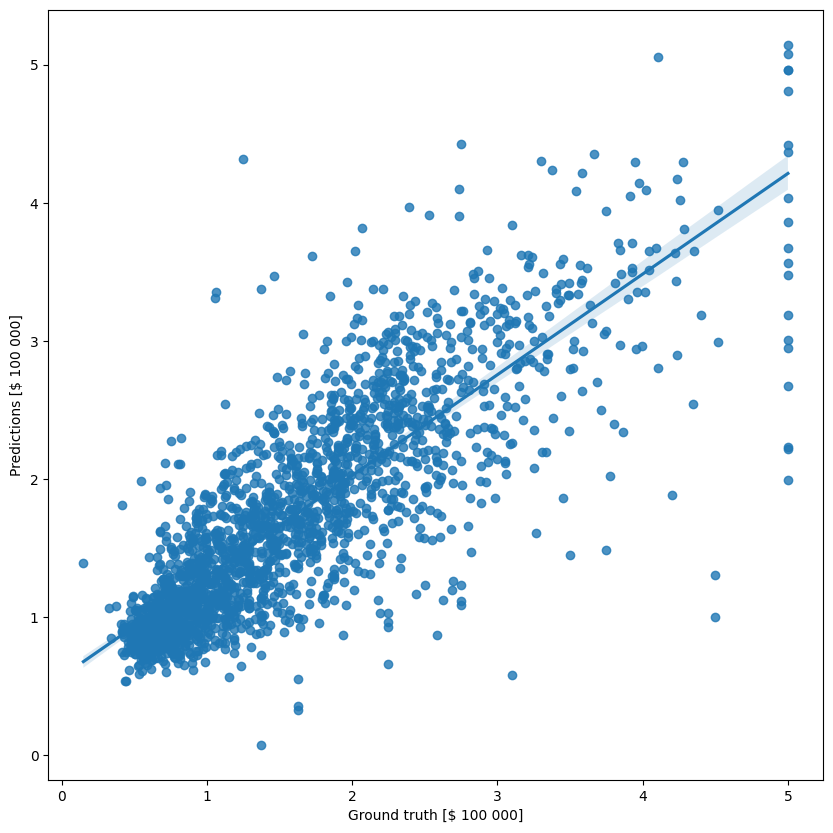

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
fig = sns.regplot(x=Y_test, y=preds.reshape(-1))
# fig.set(xlim=(10,30),ylim=(10,30))
plt.xlabel("Ground truth [$ 100 000]")
plt.ylabel("Predictions [$ 100 000]")
plt.show()

Mit jelent ez az ábra? Mit jelentene egy vízszintes egyenes? És egy függőleges egyenes?